In [1]:
import os
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
from copy import deepcopy
from collections import deque
from collections import Counter
import matplotlib.pyplot as plt
from pprint import pprint
import jinja2
import matplotlib.pyplot as plt

## Strategy 6: Monte Carlo (Decision-Making Focus)
We implemented a custom reward logic based on win priority and Blackjack rules:
|Win Condition |Description	|Reward |
| -------- | ------- |------- |
|Pair of Aces| Two Aces in opening hand|1.5|
|Blackjack (Natural)| Ace + 10/J/Q/K|1.3|
|5-Card Charlie	| 5 cards totaling ≤ 21|1.2|
|Standard Win| Total ≤ 21, beats dealer|1.0|
|Tie|	Equal hand value as dealer|0.0|
|Loss|	Bust or lower hand than dealer|-1.0|

The Reward structure is such that the learning agent will prioritise stronger winning hands as not all wins are equal.

We will be exploring Monte Carlo reinforcement learning methods to determine the optimal policy for when to "hit" or "stand" in Blackjack (decision-making focus).
1. MC First Search
2. MC Tree Search
3. MC On Policy
4. MC Off Policy

We trained each agent over 500,000 simulated rounds using a fixed $10 bet (keep bet sizing constant) and evaluated it using:
1. Win Rate
2. Expected Return

For the MC model with the best Win Rate and Expected Return, we then evaluate its robustness and attempt to draw applicable insights.

---

### Part 1 - Defining the Environment

Below, we define a basic Blackjack environment. Do refer to inline comments for precise explanations on certain parts of the code.

In [2]:
class Blackjack:
     
    def __init__(self):
        
        self.game_state = None
    
    def _get_state_dim(self):
        
        """
        State Dims:
        2: Player has Usable Ace or not
        10: Player's Hand sum (12 to 21)
        10: Dealer's visible card (Ace to 10)
        """
        
        return (2, 10, 10)
    
    def _get_action_dim(self):
        
        """
        Action Dims:
        2: Player can choose to Stand or Hit
        """
        
        return 2
    
    def _get_state_action_dim(self):
        
        """
        Combination of State and Action Dims described above
        """
        
        return tuple(list(self._get_state_dim()) + [self._get_action_dim()])
        
    def draw_card(self):
        if len(self.deck) == 0:
            raise ValueError("Deck is empty before round ended.")
        card_index = self.deck.pop()
        card_value = min(card_index, 10)
        return card_index, card_value


    def label_hand(self, cards):
        """
        Labels a hand based on game-defined priorities.
        Input: cards = list of card indices (1-13)
        Output: string label
        """

        # Helper to get card value
        values = [min(c, 10) for c in cards]
        total = sum(values)

        if len(cards) == 2 and sorted(cards) == [1, 1]:
            return "Pair of Aces"
        elif len(cards) == 2 and 1 in cards and any(c in [10, 11, 12, 13] for c in cards):
            return "Blackjack (Natural)"
        elif len(cards) == 5 and total <= 21:
            return "5-Card Charlie"
        elif total <= 21:
            return "Regular"
        return "Bust"
    
    def _update_game_state(self):
        
        self.game_state = [1 if self.player_usable_ace else 0, self.player_sum, self.dealer_visible_card_value]
        
    def reset(self):
        # Build fresh single deck (4 copies of cards 1–13)
        self.deck = [card for card in range(1, 14) for _ in range(4)]
        random.shuffle(self.deck)

        self.player_sum = 0
        self.player_cards_drawn = []
        self.player_usable_ace = False
        self.player_usable_ace_count = 0

        self.dealer_sum = 0
        self.dealer_cards_drawn = []
        self.dealer_usable_ace = False
        self.dealer_usable_ace_count = 0
        self.dealer_visible_card_value = None
        
        # Initialize all relevant variables
        self.player_sum = 0
        self.player_cards_drawn = []
        self.player_usable_ace = False
        self.player_usable_ace_count = 0
        
        self.dealer_sum = 0
        self.dealer_cards_drawn = []        
        self.dealer_usable_ace = False
        self.dealer_usable_ace_count = 0
        self.dealer_visible_card_value = None
        
        # Initialize Player Hand - The player will keep drawing cards until their hand shows a minimum of 12, as before that it 
        # only makes sense to hit instead of stand - As such, state values showing player hand value range from 12 to 21
        while self.player_sum < 12:
            
            card_index, card_value = self.draw_card()
            
            # Adds 11 for Ace initially; adjusted later if player busts and has a usable Ace
            self.player_sum += 11 if card_index == 1 else card_value
            
            # If a player draws a usable ace, we increment the usable ace flag and counter
            if card_index == 1:
                
                self.player_usable_ace_count += 1
                self.player_usable_ace = True
                
            # If a player busts but has a usable ace, we decrement the usable ace counter and player sum by 10,
            # showing that the player "used" the ace to save themselves from becoming bust
            if (self.player_usable_ace_count >= 1 and self.player_sum > 21):

                self.player_sum -= 10
                self.player_usable_ace_count -= 1
                
            if self.player_usable_ace_count == 0:
                
                self.player_usable_ace = False
                
            self.player_cards_drawn.append(card_index)
            
        # Initialize Dealer Hand - "Visible/First" Card - Only one card is drawn as only that is needed to initialize the game
        dealer_visible_card_index, self.dealer_visible_card_value = self.draw_card()
        
        self.dealer_sum += 11 if dealer_visible_card_index == 1 else self.dealer_visible_card_value
        
        if dealer_visible_card_index == 1:
        
            self.dealer_usable_ace_count += 1
            self.dealer_usable_ace = True
        
        self.dealer_cards_drawn.append(dealer_visible_card_index)
        
        # Return initialized game state
        # We use a helper function to "update" the game state which converts the boolean player_usable_ace flag into a binary
        # which will be required for array indexing by the agent Q_sa 
        self._update_game_state()
        
        return self.game_state
    

    def play(self, player_action):

        # If player chooses to Stand, Dealer's turn to finish their Hand (i.e. draw according to their until stopped or bust) 
        if player_action == 0:
            
            # Simulate rest of Dealer Hand
            while ((self.dealer_sum <= 16 and self.dealer_usable_ace == False) or (self.dealer_sum <= 17 and self.dealer_usable_ace == True)): # Dealer Policy

                card_index, card_value = self.draw_card()

                self.dealer_sum += 11 if card_index == 1 else card_value

                # Dealer follows same ace using logic as the player, described above. Will not repeat explanations here
                # to minimize comments
                if card_index == 1:

                    self.dealer_usable_ace_count += 1
                    self.dealer_usable_ace = True

                if (self.dealer_usable_ace_count >= 1 and self.dealer_sum > 21):

                    self.dealer_sum -= 10
                    self.dealer_usable_ace_count -= 1

                if self.dealer_usable_ace_count == 0:

                    self.dealer_usable_ace = False                

                self.dealer_cards_drawn.append(card_index)
                
            self._update_game_state()
            
            # Get final player hand label
            player_label = self.label_hand(self.player_cards_drawn)

            # Dealer bust
            if self.dealer_sum > 21:
                # Checks for Win priority conditions
                if player_label == "Pair of Aces":
                    return 1.5, self.game_state, True
                elif player_label == "Blackjack (Natural)":
                    return 1.3, self.game_state, True
                elif player_label == "5-Card Charlie":
                    return 1.2, self.game_state, True
                elif player_label == "Regular":
                    return 1, self.game_state, True
                else:
                    return -1, self.game_state, True  # bust

            # Dealer didn't bust
            if self.player_sum > self.dealer_sum and self.player_sum <= 21:
                # Checks for Win priority conditions
                if player_label == "Pair of Aces":
                    return 1.5, self.game_state, True
                elif player_label == "Blackjack (Natural)":
                    return 1.3, self.game_state, True
                elif player_label == "5-Card Charlie":
                    return 1.2, self.game_state, True
                else:
                    return 1, self.game_state, True

            elif self.player_sum == self.dealer_sum:
                return 0, self.game_state, True

            else:
                return -1, self.game_state, True
            
        # If player chooses to Hit, they draw 1 card at a time. If bust, then return loss rewards, state, done = True
        # If not bust, return zero rewards, state, done = False and agent will decide whether to Hit or Stand again 
        card_index, card_value = self.draw_card()

        # Adds 11 for Ace initially; adjusted later if player busts and has a usable Ace
        self.player_sum += 11 if card_index == 1 else card_value

        if card_index == 1:

            self.player_usable_ace_count += 1
            self.player_usable_ace = True

        if (self.player_usable_ace_count >= 1 and self.player_sum > 21):

            self.player_sum -= 10
            self.player_usable_ace_count -= 1
            
        if self.player_usable_ace_count == 0:

            self.player_usable_ace = False  

        self.player_cards_drawn.append(card_index)
        
        self._update_game_state()

        if self.player_sum > 21:

            return -1, self.game_state, True
        
        assert self.player_sum <= 21
        
        return 0, self.game_state, False
        

In [ ]:
# Defining helper functions to assist in testing the trained agents above, and plotting the Q_sa values later during the analysis phase

# Bet sizing 
def play_test(agent, n):
    win = 0
    blackjack_wins = 0
    tie = 0
    loss = 0

    for i in range(n):
        env = Blackjack()
        state = env.reset()
        total_reward = 0
        done = False

        while not done:
            action = agent.act(state)
            reward, next_state, done = env.play(action)
            state = next_state
            total_reward += reward

        # model learning based off win reward > tie reward > loss reward 
        if reward == 0:
            tie += 1
        elif reward == 1.5:
            win += 1
            blackjack_wins += 1
        elif reward == 1:
            win += 1
        elif reward == -1:
            loss += 1

    results_dict = {}
    results_dict['Win Rate'] = win / n
    results_dict['Tie Rate'] = tie / n
    results_dict['Loss Rate'] = loss / n
    results_dict['Expected Return'] = (
        results_dict['Win Rate'] * 10       # player wins his bet value
        + results_dict['Loss Rate'] * -10   # player loses his bet value
    )

    return results_dict


# plotter for Q-sa values
def plotter(agent):
    
    fig = plt.figure(figsize = (15, 9))
    
    ax0 = fig.add_subplot(121, projection = '3d')
    ax1 = fig.add_subplot(122, projection = '3d')

    for idx, ua in enumerate(agent.Q_sa):    

        player_sums = []
        dealer_visible_cards = []
        max_values = []
        actions = []

        for ps in range(10):

            for dv in range(10):

                max_value = -1e6
                action = None

                for i, v in enumerate(ua[ps][dv]):

                    if v > max_value:

                        max_value = v
                        action = i

                player_sums.append(ps + 12)
                dealer_visible_cards.append(dv)
                max_values.append(max_value)
                actions.append('r' if action == 0 else 'g')

        width = depth = 1

        eval(f'ax{idx}').bar3d(dealer_visible_cards, player_sums, 0, width, depth, max_values, shade = True, color = actions)
        eval(f'ax{idx}').set_title(f'{"No " if idx == 0 else ""}Usable Ace')
        
        eval(f'ax{idx}').set_xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
        eval(f'ax{idx}').set_yticks([12, 13, 14, 15, 16, 17, 18, 19, 20, 21])        
        
        eval(f'ax{idx}').set_xlabel('Dealer displayed card value (Ace = 1)', labelpad = 20)
        eval(f'ax{idx}').set_ylabel('Player Hand Sum', labelpad = 15)
        eval(f'ax{idx}').set_zlabel('Expected Reward following Best Action', labelpad = 10)
        
        eval(f'ax{idx}').tick_params(axis = "x", pad = 15)
        eval(f'ax{idx}').tick_params(axis = "y", pad = 10)
        eval(f'ax{idx}').tick_params(axis = "z", pad = 5)
        
    fig.suptitle(f'Final Q_sa plot for {agent.name} after 500k training iterations', fontsize = 16)
    plt.tight_layout()
    plt.show()


---

### Part 2 - Defining the Monte Carlo Agent

Below, we define an agent modelled after each Monte Carlo method. The performance of all 4 MC agents will be compared in the analysis section. 

In [ ]:
class AgentMC:
    
    # we choose a gamma of 1.0 throughout this exercise as Blackjack episodes are not very long and the reward received is nearly imminent
    def __init__(self, Env, epsilon = 0.1, gamma = 1.0):
        
        self.Env = Env
        self.gamma = gamma # discount rate
        self.epsilon = epsilon # default target policy exploration rate
        self.epsilon_b = 0.50 # behavioral policy exploration rate   
        self.delta = 1e-7 # delta for convergence condition
        
        self.state_dims = self.Env._get_state_dim()
        self.state_action_dims = self.Env._get_state_action_dim()
        
        # Order: Usable Ace, Player Sum, Dealer Visible Card (Ace index 0), Action
        self.V_s = np.zeros(self.state_dims)
        self.Q_sa = np.zeros(self.state_action_dims)
        self.Q_sa_history = []
        
        # Dictionary to store state-action pairs
        self.visits_sa = dict([((i, j, k, l), 0) for i in range(self.state_action_dims[0]) \
                                                 for j in range(self.state_action_dims[1]) \
                                                 for k in range(self.state_action_dims[2]) \
                                                 for l in range(self.state_action_dims[3]) \
                              ])
                
    # the target policy is epsilon greedy
    def target_policy(self, state, behavioral = False, act = False):
        
        state = deepcopy(state)
        
        # State and Next State values need to be adjusted such that indices fit within the Q_sa
        state[1] -= 12
        state[2] -= 1
        
        epsilon = self.epsilon_b if behavioral == True else self.epsilon 
        epsilon = epsilon if act == False else 0
        
        if np.random.rand() < epsilon:
            
            return np.random.choice(2) # random action
        
        else:
            
            max_q_value = np.max(self.Q_sa[tuple(state)])
            max_indices = np.where(self.Q_sa[tuple(state)] == max_q_value)[0]
            
            return np.random.choice(max_indices)
        
    # behavioral policy is also epsilon greedy, but with a higher epsilon value to encourage more exploration
    def behavioral_policy(self, state):
        
        return self.target_policy(state, behavioral = True)
    
    # returns an epsiode of a Blackjack game (episode - start to finish)
    def sample_episode(self):
        
        episode = []
        state = self.Env.reset()
        
        done = False
        
        while not done:
            
            action = self.target_policy(state)            
            reward, next_state, done = self.Env.play(action)
            episode.append(deepcopy((state, action, reward)))
            state = next_state
        
        return episode
    
    # when agent is trained, this method performs the greedy action to maximise expected returns
    def act(self, state):
        
        return self.target_policy(state, act = True)

    # First Training paradigm - First Search vs. Tree Search
    def predict_q(self, num_episodes, first_Search = True):
        
        self.name = f'Monte Carlo - {"First" if first_Search else "Tree"} Search'
        
        for _ in tqdm(range(num_episodes)):

            episode = self.sample_episode()
            G = 0
            visited_sa_pairs = set()

            future_rewards = np.zeros(len(episode))
            before_update = np.sum(deepcopy(self.Q_sa))
            self.Q_sa_history.append(before_update)
            
            for i, (state, action, reward) in enumerate(reversed(episode)):
                
                G = reward + self.gamma * G
                future_rewards[-(i+1)] = G

            for i, (state, action, reward) in enumerate(episode):
                
                state[1] -= 12
                state[2] -= 1
        
                G = future_rewards[i]
                sa_tuple = tuple(state+[action])

                if first_Search:
                    if sa_tuple in visited_sa_pairs:
                        continue
                    else:
                        visited_sa_pairs.add(sa_tuple)
                        
                self.visits_sa[sa_tuple] += 1
                self.Q_sa[sa_tuple] += 1/(self.visits_sa[sa_tuple]) * (G - self.Q_sa[sa_tuple])
                
            after_update = np.sum(deepcopy(self.Q_sa))
            delta = abs(after_update - before_update)

            # # The following convergence termination code has been commented out in order to allow all agents to be trained on an equal no. of iterations for analysis later on
            # if delta < self.delta and delta != 0 and delta >= 1e-13:
            #     print(f'[{self.name} - CONVERGED] Training Stopped at Episode {_}. Delta: {delta}')
            #     break        
            
    # Second Training paradigm - On Policy vs. Off Policy                
    def GPI(self, num_episodes, on_policy = True):
        
        self.name = f'Monte Carlo - {"On" if on_policy else "Off"} Policy'
        
        for _ in tqdm(range(num_episodes)):
            
            episode = []
            state = self.Env.reset()
            
            done = False
            
            while not done:
                
                if on_policy:
                    action = self.target_policy(state)
                else:
                    action = self.behavioral_policy(state)
                
                reward, next_state, done = self.Env.play(action)
                episode.append(deepcopy((state, action, reward)))
                state = next_state
                
            before_update = np.sum(deepcopy(self.Q_sa))
            self.Q_sa_history.append(before_update)

            G = 0
            W = 1  # Importance sampling ratio
            for state, action, reward in reversed(episode):
                
                state[1] -= 12
                state[2] -= 1
                
                sa_tuple = tuple(state + [action])

                G = reward + self.gamma * G
                self.visits_sa[sa_tuple] += W
                self.Q_sa[sa_tuple] += W / self.visits_sa[sa_tuple] * (G - self.Q_sa[sa_tuple])
                
                if not on_policy:
                    
                    behavior_prob = self.epsilon_b if action != np.argmax(self.Q_sa[tuple(state)]) else (1-self.epsilon_b) # chance of not following greedy under bp
                    target_prob = self.epsilon if action != np.argmax(self.Q_sa[tuple(state)]) else (1-self.epsilon) # chance of not following greedy under tp
                    
                    W *= target_prob / behavior_prob
                    
                    if W == 0:
                        break
                        
            after_update = np.sum(deepcopy(self.Q_sa))
            delta = abs(after_update - before_update)
            
            # # The following convergence termination code has been commented out in order to allow all agents to be trained on an equal no. of iterations for analysis later on
            # if delta < self.delta and delta != 0 and delta >= 1e-13:
            #     print(f'[{self.name} - CONVERGED] Training Stopped at Episode {_}. Delta: {delta}')
            #     break    


---

### Part 3 - Models Training

Now that we have defined the agents above, we train a set of 4 agents with 500k iterations each.

In [5]:
# Set seed to store training results 
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

# Trained models will be saved into this list for analysis later
trained_Blackjack_agents = []

# Monte Carlo First Search
player_MC_first_Search = AgentMC(Blackjack())
player_MC_first_Search.predict_q(500000, first_Search = True)
trained_Blackjack_agents.append(player_MC_first_Search)

# Monte Carlo Tree Search
player_MC_tree_Search = AgentMC(Blackjack())
player_MC_tree_Search.predict_q(500000, first_Search = False)
trained_Blackjack_agents.append(player_MC_tree_Search)

# Monte Carlo On Policy
player_MC_on_policy = AgentMC(Blackjack())
player_MC_on_policy.GPI(500000, on_policy = True)
trained_Blackjack_agents.append(player_MC_on_policy)

# Monte Carlo Off Policy
player_MC_off_policy = AgentMC(Blackjack())
player_MC_off_policy.GPI(500000, on_policy = False)
trained_Blackjack_agents.append(player_MC_off_policy)


100%|██████████| 500000/500000 [00:43<00:00, 11479.48it/s]


---

### Part 4 Model Testing
Each agent will be tested over 300 games to evaluate their performance, as measured by Win Rate (against House) and Expected Returns.

In [66]:
# Run 300 simulated games per agent to see which ones perform best
key_result_columns = ['Expected Return', 'Win Rate']
results_dict = {}

for agent in tqdm(trained_Blackjack_agents):
    
    results_dict[agent.name] = play_test(agent, 300)
    
df = pd.DataFrame(results_dict).T

100%|██████████| 4/4 [00:00<00:00, 61.13it/s]


In [67]:
# Generate results table for Monte Carlo agents
mc_results_df = df.filter(like = 'Monte Carlo', axis = 0)
mc_results_df = mc_results_df.style.set_properties(**{'background-color':'gold'}, subset = key_result_columns)\
                             .highlight_max(props = 'color:green;font-weight: bold', axis = 0, subset = key_result_columns)\
                             .format({
                                      'Win Rate': '{:,.2%}'.format,
                                      'Non-Blackjack Win Rate': '{:,.2%}'.format,
                                      'Blackjack Win Rate': '{:,.2%}'.format,
                                      'Tie Rate': '{:,.2%}'.format,
                                      'Loss Rate': '{:,.2%}'.format,
                                     })
mc_results_df


,Win Rate,Tie Rate,Loss Rate,Expected Return
Monte Carlo - First Search,43.67%,7.00%,46.67%,-0.300000
Monte Carlo - Every Search,38.67%,10.67%,44.00%,-0.533333
Monte Carlo - On Policy,38.67%,8.33%,47.00%,-0.833333
Monte Carlo - Off Policy,37.67%,7.33%,48.00%,-1.033333


Viewing the results for the Monte Carlo Agents, above we see that **the Monte Carlo - First Search  agent has the best win rate of 43.67%** and the best expected return of **-0.30**, which is computed based on the Win Rates multiplied by the expected rewards of a standard win, Blackjack win or a loss.

Nevertheless, we note that all MC models are very close in their performance, and are not deterministic. The best model can change from training run to training run and the MC model with the highest winrate is not necessarily the MC model with the highest returns, and vice versa.

---

### Part 5: Analysis of Monte Carlo First Search
We further analyse the performance of the Monte Carlo - First Search model since it gave the highest Expected Return.

5.1: Visualize convergence of Q_sa using np.sum(Q_sa) across training iterations

5.2: Plot the agent’s learned state-action values, separated by usable vs. non-usable Ace

The plots show that convergence typically occurs before 500,000 episodes. We also observe clearer decision boundaries when the player has a usable Ace — a sign that the policy is exploiting advantageous hand states effectively.

#### 5.1: Visualize Q_sa convergence of  MCFS

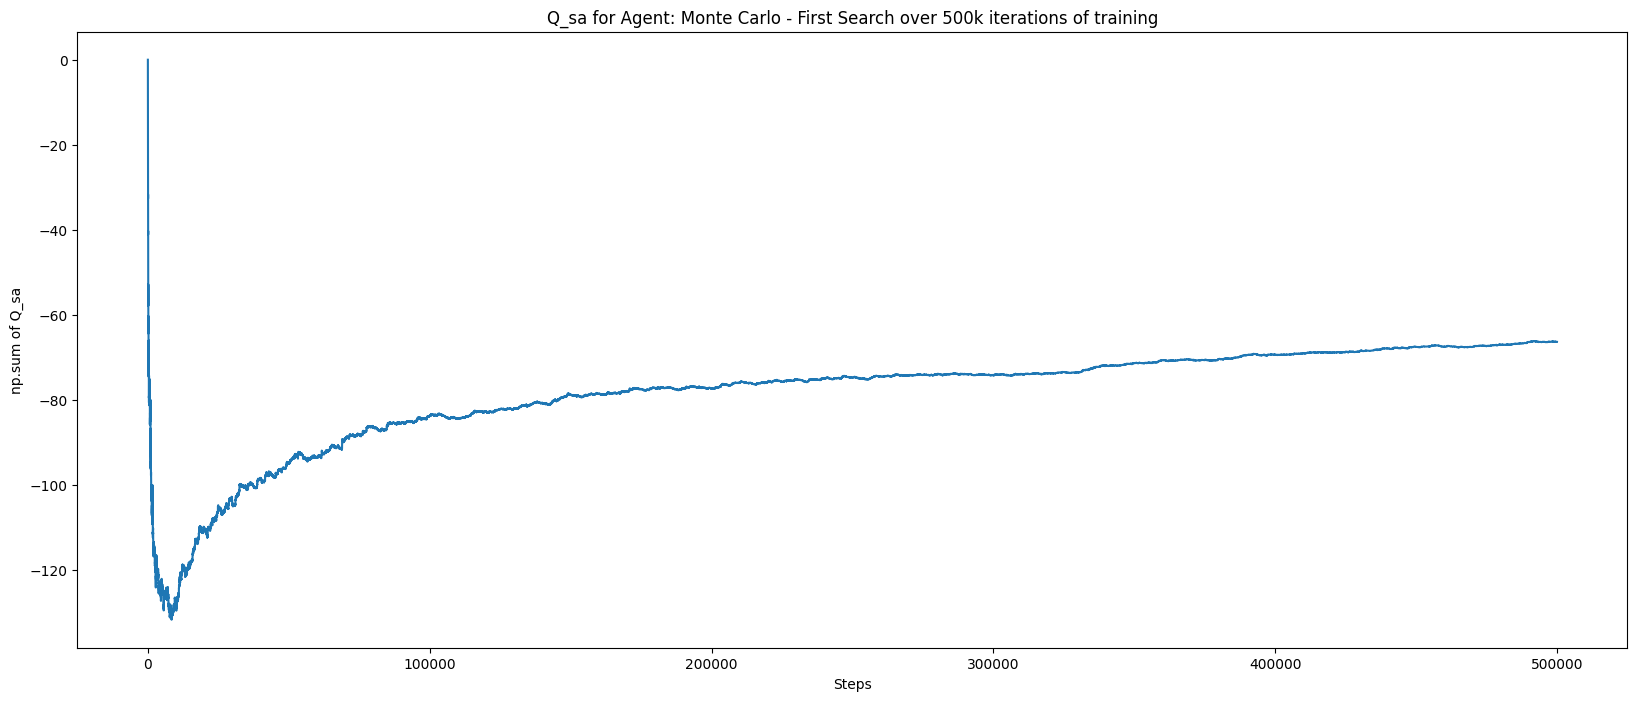

In [68]:
# Only get the best Monte Carlo model based on Expected Return
best_model_name = df.filter(like='Monte Carlo', axis=0).idxmax(axis=0)['Expected Return']
best_agents = [agent for agent in trained_Blackjack_agents if agent.name == best_model_name]

# Code to plot Q_sa, to illustrate convergence of the best MC model
fig, ax = plt.subplots(1, 1, figsize=(20, 8))

ax.plot(best_agents[0].Q_sa_history)
ax.set_xlabel('Steps')
ax.set_ylabel('np.sum of Q_sa')
ax.set_title(f'Q_sa for Agent: {best_agents[0].name} over 500k iterations of training')

plt.show()

The initial volatility reflects the agent's exploration of bad actions — a necessary part of Monte Carlo learning. As training progresses, the Q-values steadily rise, indicating better action-value estimates. By about 300,000 episodes, the learning curve flattens, confirming that the agent has converged to a stable policy. Hence we conclude that the MC First Search agent has learned effectively without needing additional heuristics or function approximation

#### 5.2: Visualise MCFS’s learned state-action values (Usable vs non-Usable Ace)

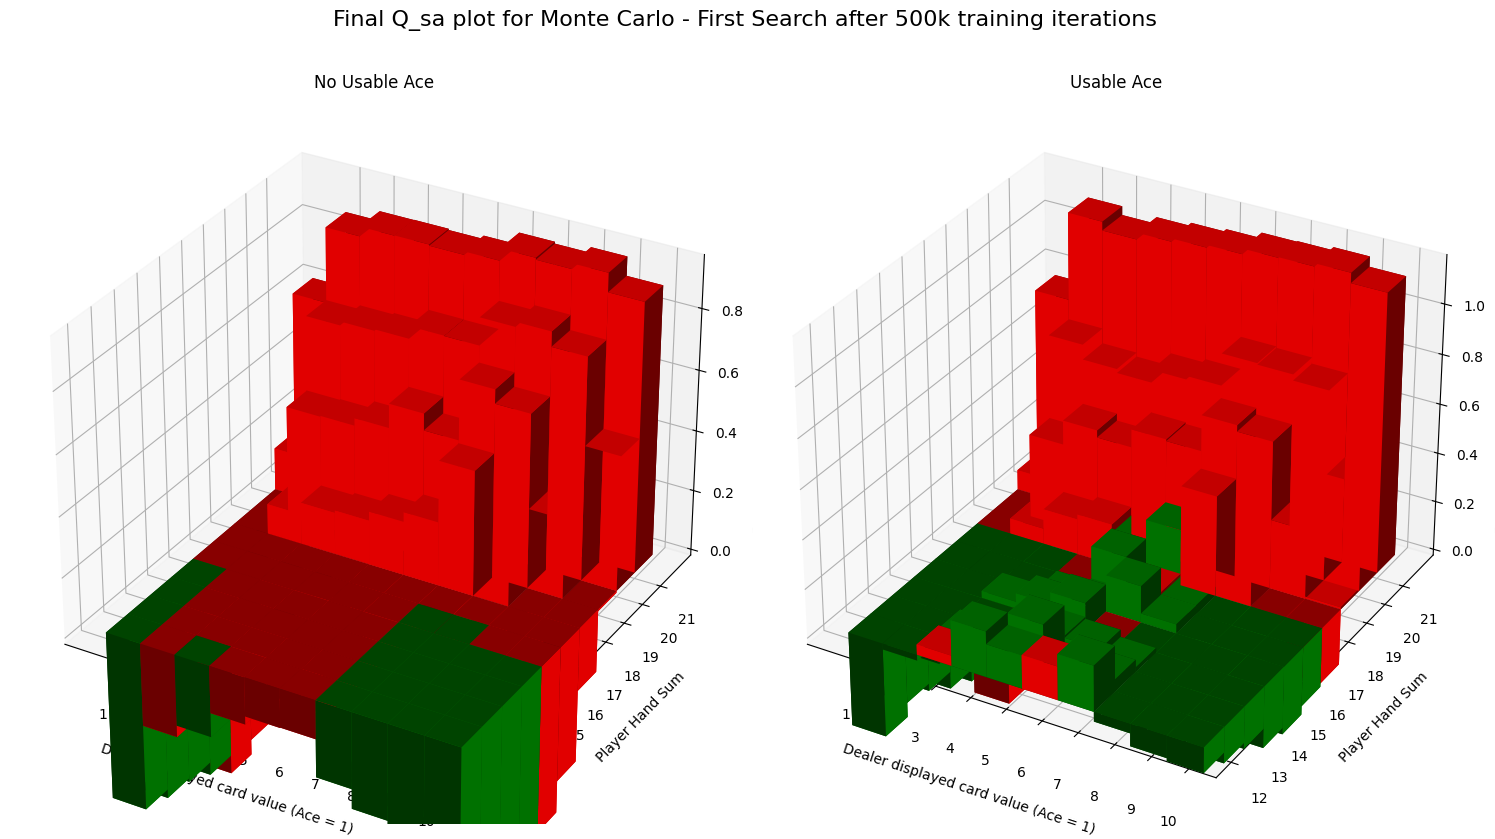

In [69]:
plotter(best_agents[0])

For the plot above, the <font color='green'>**green**</font> regions indicate states where the best action taken is to <font color='green'>**Hit**</font>. Conversely, the <font color='red'>**red**</font> regions indicate states where the best action taken is to <font color='red'>**Stand**</font> - Essentially, the Greedy Policy learned.

We can see that the higher the starting value of a player's hand, the agent has learned to <font color='red'>**Stand**</font>, and subsequently attain a higher Expected Reward, indicated by the "wall of red" towards the back of the plot above. Conversely, the lower the starting value of a player's hand, the agent has learned to <font color='green'>**Hit**</font>, but despite this, the Expected Reward tends to be mostly negative, or only very slightly positive in the "Usable Ace" case. Intuitively, this makes sense, as this game is ultimately designed to make the house money over the long run. This is further corroborated by the fact that the Expected Reward we saw for this agent above is **-0.30**. Being slightly negative ensures that in the long run, the player is never the bigger winner than the house.

Comparing the No Usable Ace vs. the Usable Ace plots, we see that having a Usable Ace certainly has its advantages, as even at smaller Player Hand sums, one can still Expect a slight positive reward compared to not having a Usable Ace. It is however, interesting to note that while in the Usable Ace plot, at smaller Player Hand sums, the actions is almost always to <font color='green'>**Hit**</font>, while in the No Usable Ace plot, at smaller Player Hand sums, some actions still include <font color='red'>**Stand**</font>. One possible reason for this could be that due to the lack of a Usable Ace, the agent is risk-averse in taking more cards, as may be relying on the Dealer to go bust instead. Further studies need to be conducted (or more training) to conclusive understand why such a phenomenon is taking place - perhaps this could also be a nuance of the current training cycle, where more iterations could convert that central red-region to green.  

---

### Part 5.3: (Bonus) Win Type Distribution Analysis (Monte Carlo First Search)

We further analyze how the Monte Carlo First Search Agent achieves its wins by categorizing outcomes into:
- Pair of Aces
- Blackjack (Natural)
- 5-Card Charlie
- Regular
- Bust

The following plots show the distribution of these hand labels across 300 games.


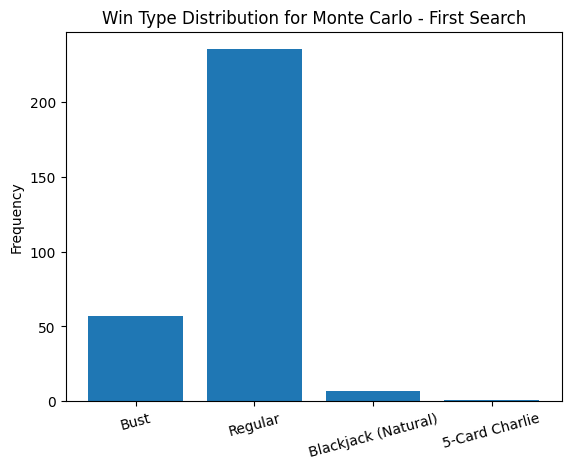

{'Bust': 57, 'Regular': 235, 'Blackjack (Natural)': 7, '5-Card Charlie': 1}

In [70]:
# Reset seed before testing to ensure consistent deck order and fair comparison
random.seed(SEED)
np.random.seed(SEED)

def win_type_distribution(agent, n=300):
    label_counter = Counter()

    for _ in range(n):
        env = Blackjack()
        state = env.reset()
        done = False

        while not done:
            action = agent.act(state)
            reward, next_state, done = env.play(action)
            state = next_state

        label = env.label_hand(env.player_cards_drawn)
        label_counter[label] += 1

    # Plot
    labels, counts = zip(*label_counter.items())
    plt.bar(labels, counts)
    plt.title(f"Win Type Distribution for {agent.name}")
    plt.ylabel("Frequency")
    plt.xticks(rotation=15)
    plt.show()

    return dict(label_counter)

win_type_distribution(best_agents[0])


While win rate and expected return tell us how often the agent wins, the win type distribution reveals how it wins. This reflects the agent’s strategic behavior and risk tolerance.

1. Pair of Aces and Natural Blackjack: These are not decisions — they’re lucky hands. A higher frequency here doesn't reflect agent skill, just deck randomness. If one agent consistently has more of these, it's likely due to randomness unless it's exploiting usable Aces effectively.

2. 5-Card Charli: This is a highly strategic win. If an agent wins frequently this way, it suggests:
It knows when to keep hitting and is playing risk-aware, aiming for incremental wins without busting. Seeing more of this is a sign of strong state-action value learning.

3. Regular Wins: This category captures hands where the agent beats the dealer without falling into the above special cases. It's the most common win type for a well-trained agent and reflects good balance between caution and aggression.

4. Busts: We see that the agent also has substantial wins by playing off the dealer going bust. The agent hasn’t learned how to actively play for this scenario given that the win count is still much lesser than playing for himself (Blackjack). The wins off these cases are likely a result in variance of dealer performance hence a passive strategy rather than an active strategy utilised by the agent.

In summary, the win type distribution offers a window into qualitative performance, not just quantitative results — reinforcing that our agent doesn't just win often, it wins well.

Yet, Machine Learning insights are often a blackbox and insights are not always easily intrepetable and hence utilised. Here, we attempt to translate these machine learning insights into human actionable actions. 

#### Analysis for Monte Carlo - First Search
1. The most common outcome was Regular, accounting for 78.3% of games.
2. Rare use of 5-Card Charlies at 0.33% implies a more cautious or early-stand policy.
3. Modest Bust rate 0f 19% indicates controlled decision-making under risk.
4. Natural Blackjacks accounted for 2.33% of winning hands — generally luck-based, not policy-driven.
5. Pair of Aces occurred in 0% of games — a rare but high-reward event.

---

### Part 6 - Conclusion and Suggestions

Overall, the results observed above align with theoretical expectations. Research suggests that the typical win rate in Blackjack is between 40% and 45%. Our best-performing Monte Carlo agent — First-Search MC — achieved a win rate of **43.67%**, with a consistent expected return that confirms the principle that the house wins in the long run.

Beyond win rates, our analysis showed that the agent often won through regular hands and calculated plays — with low bust rates and strategic 5-card wins, suggesting learned risk management rather than brute-force play. These are the kinds of insights that make machine learning interpretable and actionable.

Of course, while it may be difficult to replicate Monte Carlo First Search decisions at the dinner table during Chinese New Year, the real takeaway is how AI models like this can learn to make sound decisions under uncertainty, even in leisure contexts. After all, creating memories and enjoying a fun, supportive environment with our red packet money matters more than winning every single round.

One possible improvemnet is to incorporate reinforcement learning methods beyond pure Monte Carlo, such as Temporal-Difference (TD) learning or hybrid methods like TD(λ). MC methods suffer from high variance and require full episodes before learning updates. TD methods learn more efficiently by updating Q-values at every time step, and hybrids can balance long-term planning with sample efficiency.

---

### References

The following GitHub repositories were used as reference in building the environment and agent scripts:

1. https://medium.com/mitb-for-all/reinforcement-learning-optimal-blackjack-strategies-982a5a176d2d
2. https://github.com/jovsa/rl-examples-sutton-and-barto-book/blob/master/chapter05/Blackjack.py

---